In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from star_flow import FlowMatchingModel 

In [10]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/9mzh1db9/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/9mzh1db9/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt


In [11]:
def predict_star_map(total_mass_map, num_steps=100):

    # Convert to tensor: (1, 1, H, W)
    input_tensor = torch.FloatTensor(total_mass_map).unsqueeze(0).unsqueeze(0).to(device)
    
    # Generate star map
    with torch.no_grad():
        output = model.sample(input_tensor, num_steps=num_steps)
    
    # Convert back to numpy and denormalize
    star_map = output.cpu().numpy()[0, 0]

    
    return star_map

In [12]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
star_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
star = np.log1p(star_maps)
tot_mean,tot_std = tot.mean(), tot.std()
star_mean,star_std = star.mean(), star.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std,
    'star_mean': star_mean,
    'star_std': star_std
}

sample_tot = np.log1p(total_mass_maps[0])

sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

pred_star = predict_star_map(sample_tot, num_steps=300)
true_star = (np.log1p(star_maps[0]) - data_stats['star_mean'])/data_stats['star_std']

In [13]:
import Pk_library as PKL

# parameters
BoxSize = 25.0    
MAS     = 'None'  
threads = 1       


# compute the Pk of that delta
Pk2D_pred = PKL.Pk_plane(pred_star, BoxSize, MAS, threads)

Pk2D_true = PKL.Pk_plane(true_star, BoxSize, MAS, threads)

k_pred      = Pk2D_pred.k   
Pk_pred     = Pk2D_pred.Pk    

k_true      = Pk2D_true.k   
Pk_true     = Pk2D_true.Pk


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


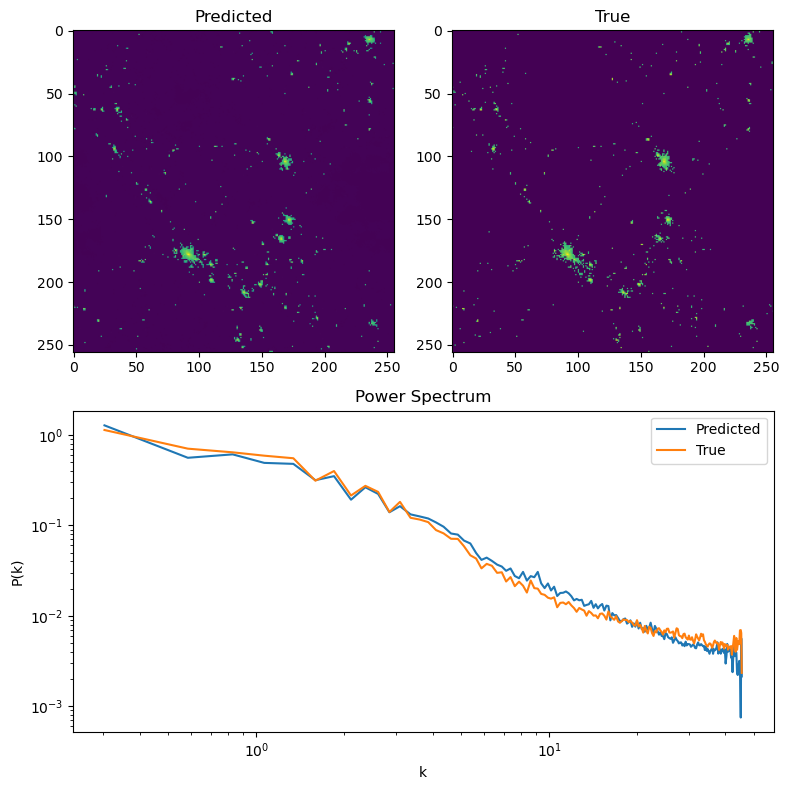

In [14]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create 2x2 layout with custom height/width
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Top row: image plots
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Predicted")
ax1.imshow(pred_star)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("True")
ax2.imshow(true_star)

# Bottom row: merged plot across both columns
ax3 = fig.add_subplot(gs[1, :])  # spans both columns
ax3.set_title("Power Spectrum")
ax3.loglog(k_pred, Pk_pred, label="Predicted")
ax3.loglog(k_true, Pk_true, label="True")
ax3.legend()
ax3.set_xlabel("k")
ax3.set_ylabel("P(k)")

plt.tight_layout()
plt.savefig("sample.png")
plt.show()


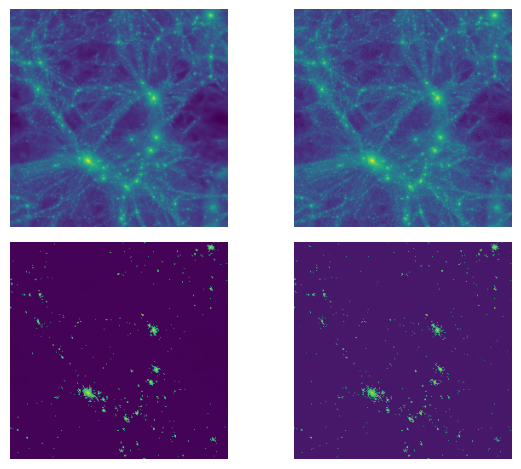

In [26]:
gaussian_noise = np.random.normal(loc=0.0, scale=0.2, size=(256, 256))
pred_star_noisy = predict_star_map(sample_tot + gaussian_noise, num_steps=300)

plt.subplot(2,2,1)
plt.imshow(sample_tot)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(pred_star)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(sample_tot+gaussian_noise)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(pred_star_noisy)
plt.axis('off')
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1284192/4059744835.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.loglog(k_noisy, Pk_noisy, color='grey', alpha=0.4, linewidth=0.8, ls='--', label=f'$\sigma$={sigma}')


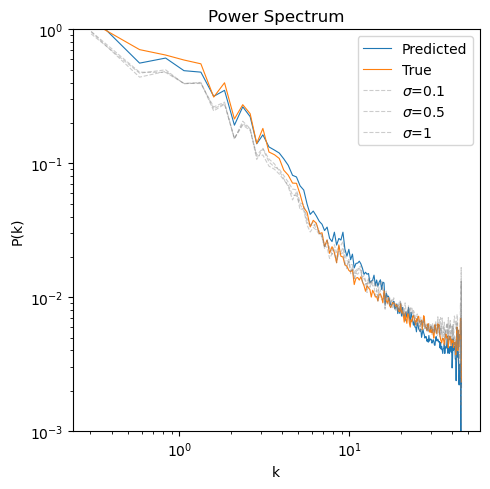

In [35]:

plt.figure(figsize=(5, 5))
plt.title("Power Spectrum")

# Plot the predicted and true curves
plt.loglog(k_pred, Pk_pred, label="Predicted", linewidth=0.8)
plt.loglog(k_true, Pk_true, label="True", linewidth=0.8)

# Sample and plot Gaussian noise spectra
for sigma in [0.1,0.5,1]:
    gaussian_noise = np.random.normal(loc=0.0, scale=noise_scale, size=(256, 256))
    pred_star_noise = predict_star_map(sample_tot + gaussian_noise, num_steps=300)

    Pk2D_noisy = PKL.Pk_plane(pred_star_noise, BoxSize, MAS, threads, verbose=False)
    k_noisy = Pk2D_noisy.k
    Pk_noisy = Pk2D_noisy.Pk

    plt.loglog(k_noisy, Pk_noisy, color='grey', alpha=0.4, linewidth=0.8, ls='--', label=f'$\sigma$={sigma}')

# Finalize plot
plt.xlabel("k")
plt.ylabel("P(k)")
plt.ylim(1e-3,1)
plt.legend()
plt.tight_layout()
plt.savefig("pk_scale.png")
plt.show()


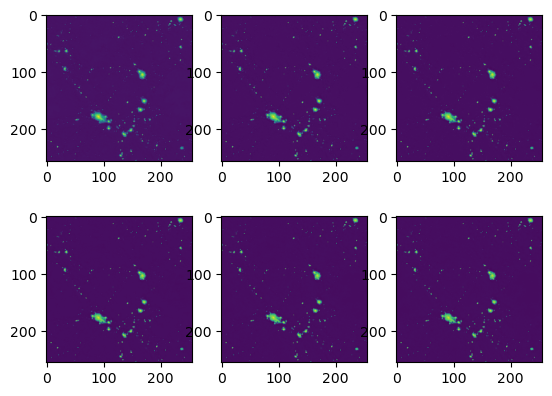

In [32]:
for i , num in enumerate([1,2,3,4,5,6]):
    pred_star = predict_star_map(sample_tot, num_steps=num)
    plt.subplot(2,3,i+1)
    plt.imshow(pred_star)
plt.show()

In [51]:
pred_star

array([[-1.8436031e+00, -1.9783508e+00, -1.2949789e+00, ...,
        -1.7969403e+00, -1.4197591e-01,  1.3873074e+00],
       [-1.6877273e+00, -7.1941012e-01,  5.8269749e+00, ...,
        -3.5572553e-01, -1.1500916e+00, -1.2264303e+00],
       [ 6.3451014e+00, -2.5698623e-01, -4.1442919e-01, ...,
         8.1550436e+00, -7.9072583e-01,  5.4323821e+00],
       ...,
       [-4.2487222e-01, -2.3878584e+00,  8.6422262e+00, ...,
         7.0288901e+00, -1.4023261e+00, -1.8599687e+00],
       [-9.3280649e-01,  5.2121911e+00,  4.2624698e+00, ...,
         4.9505539e+00, -4.2038159e+00, -1.0403267e+00],
       [ 2.0480640e-03, -4.6493787e-01, -1.1181591e+00, ...,
        -1.8230473e+00,  2.9444723e+00, -6.0903674e-01]],
      shape=(256, 256), dtype=float32)

(array([1.2000e+01, 1.2200e+02, 6.8700e+02, 3.8270e+03, 1.3444e+04,
        1.7331e+04, 7.8280e+03, 4.3520e+03, 4.5070e+03, 4.9230e+03,
        4.0880e+03, 2.5600e+03, 1.3100e+03, 4.4000e+02, 9.0000e+01,
        1.5000e+01]),
 array([-10.10856438,  -8.44343567,  -6.77830696,  -5.11317873,
         -3.44805002,  -1.78292179,  -0.11779308,   1.54733562,
          3.21246433,   4.87759304,   6.54272079,   8.2078495 ,
          9.87297821,  11.53810692,  13.20323563,  14.86836433,
         16.53349304]),
 <BarContainer object of 16 artists>)

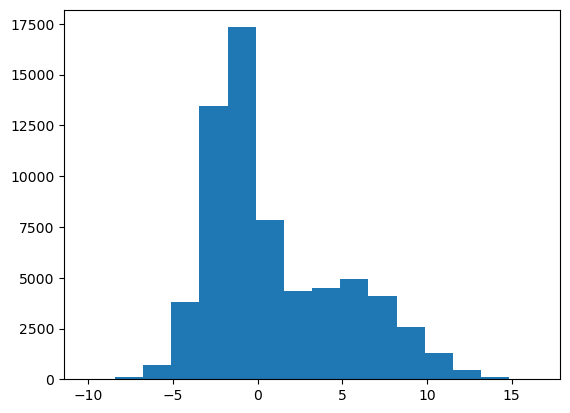

In [49]:
plt.hist(pred_star.flatten(), bins=16)

(array([6.4533e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.6600e+02, 3.2600e+02, 8.9000e+01, 2.2000e+01]),
 array([-0.11124876,  1.14087021,  2.39298916,  3.64510798,  4.89722681,
         6.14934587,  7.40146446,  8.65358353,  9.90570259, 11.15782166,
        12.40994072]),
 <BarContainer object of 10 artists>)

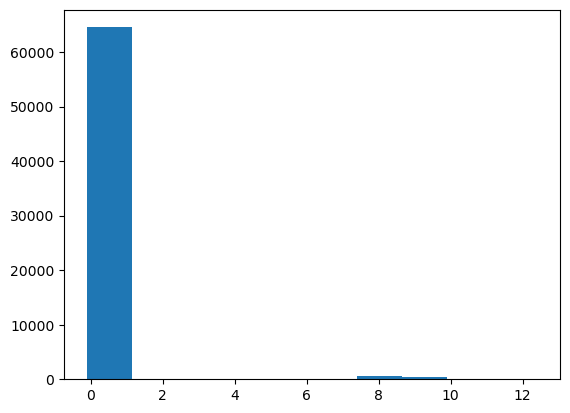

In [50]:
plt.hist(true_star.flatten())

In [42]:
true_star

array([[-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876],
       [-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876],
       [-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876],
       ...,
       [-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876],
       [-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876],
       [-0.11124876, -0.11124876, -0.11124876, ..., -0.11124876,
        -0.11124876, -0.11124876]], shape=(256, 256), dtype=float32)

In [43]:
pred_star

array([[-0.11529937, -0.3544959 , -0.28199252, ...,  7.7698264 ,
         8.263018  , -0.8767118 ],
       [-0.18759608,  6.128293  , -0.28178376, ...,  9.1816435 ,
        -0.68512315, -0.47715357],
       [ 0.04469495, -0.32514006,  7.110119  , ..., -0.43484294,
        -0.31841174,  8.431057  ],
       ...,
       [-0.24779457, -0.47704884,  8.079066  , ..., -0.21843131,
        -0.23033893, -0.21881984],
       [-0.49396095,  9.453978  , -0.4274255 , ..., -0.06627321,
        11.000671  , -0.49457717],
       [ 2.9525914 , -0.6331001 , -0.63600856, ...,  5.890571  ,
        -0.58801204,  0.6769446 ]], shape=(256, 256), dtype=float32)

In [29]:
from module import AstroFlowMatchingDataModule

total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
star_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')


tot_log = np.log1p(total_mass_maps)
star_log = np.log1p(star_maps)

test_module = AstroFlowMatchingDataModule(
        total_mass_maps=tot_log,
        star_maps=star_log,
        batch_size=32,
        val_split=0.2,
        num_workers=4
    )

In [30]:
tot_mean,tot_std = tot_log.mean(), tot_log.std()
star_mean,star_std = star_log.mean(), star_log.std()

In [31]:
test_module.setup()

Normalising with tot_log mean: 25.569, std: 1.132
Normalising with star_log mean: 0.278, std: 2.498
Normalising with tot_log mean: 25.559, std: 1.131
Normalising with star_log mean: 0.278, std: 2.498


In [32]:
tot_test, stars_test = next(iter(test_module.train_dataloader()))

In [33]:
tot_test.mean(), tot_test.std()

(tensor(0.0848), tensor(1.0168))

In [34]:
stars_test.mean(), stars_test.std()

(tensor(0.0249), tensor(1.1060))

In [35]:
((tot_log - tot_mean)/tot_std).mean()

np.float32(0.00013406905)

In [36]:
((tot_log - tot_mean)/tot_std).std()

np.float32(1.0000023)

In [12]:
stars_test.mean()

tensor(0.0128)

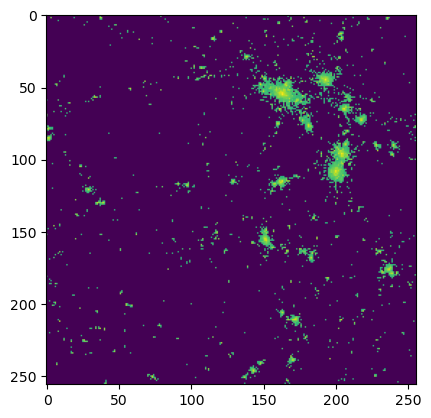

In [37]:
plt.imshow(stars_test[0,0])

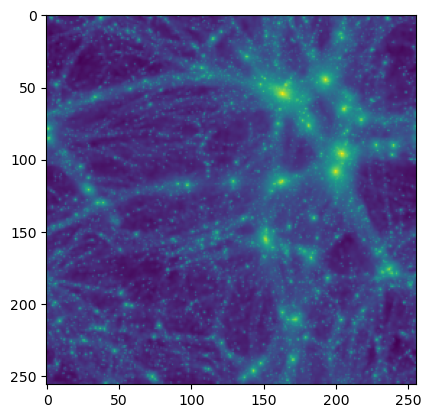

In [38]:
plt.imshow(tot_test[0].squeeze(0))

In [39]:
tot_test[0,0]

tensor([[0.2606, 0.3871, 0.4759,  ..., 0.1885, 0.1894, 0.1936],
        [0.3005, 0.5994, 1.8165,  ..., 0.2449, 0.2351, 0.2583],
        [0.3197, 0.6188, 2.5056,  ..., 2.1104, 0.5226, 0.3758],
        ...,
        [0.5719, 0.2388, 0.0703,  ..., 0.6054, 0.6152, 0.5968],
        [0.2608, 0.1137, 0.0556,  ..., 0.4003, 0.5032, 0.3924],
        [0.2152, 0.2255, 0.2388,  ..., 0.2622, 0.3084, 0.2257]])

In [42]:
stars_test[0,0]

tensor([[-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113],
        [-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113],
        [-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113],
        ...,
        [-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113],
        [-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113],
        [-0.1113, -0.1113, -0.1113,  ..., -0.1113, -0.1113, -0.1113]])

In [40]:
stars_test[0,0].std()

tensor(1.9344)

(array([6.446e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.150e+02, 3.340e+02, 8.900e+01, 3.800e+01]),
 array([-0.11096236,  1.14941299,  2.40978837,  3.67016363,  4.93053913,
         6.19091463,  7.45128965,  8.71166611,  9.97204113, 11.23241615,
        12.49279213]),
 <BarContainer object of 10 artists>)

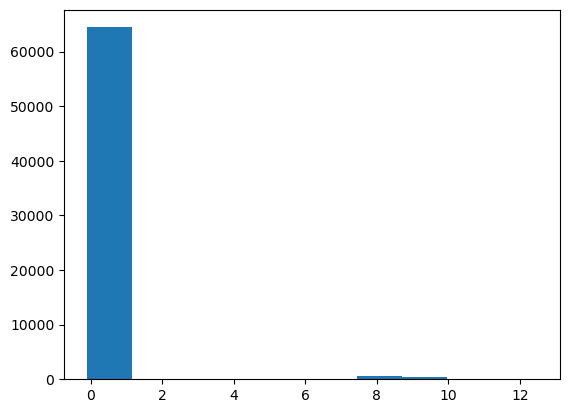

In [22]:
plt.hist((stars_test[0,0].flatten()))